In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
from PIL import Image

c:\Users\tisha\anaconda3\envs\TF\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
c:\Users\tisha\anaconda3\envs\TF\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want

In [2]:

DATA_PATH = "T:/CodeBase/Python/Computer Vision/MID/Project/FaceDetection/Faces/img"

GENERATE_RES = 2
GENERATE_SQUARE = 32 * GENERATE_RES
IMAGE_CHANNELS = 3

PREV_ROWS = 4
PREV_COLS = 7

PREV_MARGIN = 16

SEED_VAL = 100
EPOCHS = 800
BATCH_SIZE = 16
BUFFER_SIZE = 60000


In [3]:
train_data = []
for f in tqdm(os.listdir(DATA_PATH)):
    path = os.path.join(DATA_PATH, f)
    image = Image.open(path).resize((GENERATE_SQUARE, GENERATE_SQUARE), Image.LANCZOS)
    train_data.append(np.asarray(image))

100%|██████████| 20/20 [00:00<00:00, 46.27it/s]


In [4]:
train_data = np.reshape(train_data, (-1, GENERATE_SQUARE, GENERATE_SQUARE, IMAGE_CHANNELS))
train_data = train_data.astype("float32")
train_data = train_data / 127.5 - 1

print(train_data.shape)

(20, 64, 64, 3)


In [5]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_data).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [6]:
def build_generator(seed_size, channel):
    model = tf.keras.Sequential()
    model.add(layers.Dense(4 * 4 * 256, activation="relu", input_dim=seed_size))
    model.add(layers.Reshape((4, 4, 256)))

    model.add(layers.UpSampling2D())
    model.add(layers.Conv2D(256, kernel_size=3, padding="same"))
    model.add(layers.BatchNormalization(momentum=0.7))
    model.add(layers.Activation("relu"))

    model.add(layers.UpSampling2D())
    model.add(layers.Conv2D(256, kernel_size=3, padding="same"))
    model.add(layers.BatchNormalization(momentum=0.7))
    model.add(layers.Activation("relu"))

    model.add(layers.UpSampling2D())
    model.add(layers.Conv2D(256, kernel_size=3, padding="same"))
    model.add(layers.BatchNormalization(momentum=0.7))
    model.add(layers.Activation("relu"))

    if GENERATE_RES > 1:
        model.add(layers.UpSampling2D(size=(GENERATE_RES, GENERATE_RES)))
        model.add(layers.Conv2D(256, kernel_size=3, padding="same"))
        model.add(layers.BatchNormalization(momentum=0.7))
        model.add(layers.Activation("relu"))

    model.add(layers.Conv2D(channel, kernel_size=3, padding="same"))
    model.add(layers.Activation("tanh"))

    return model

In [7]:
def build_discriminator(image_shape):
    model = tf.keras.Sequential()

    model.add(layers.Conv2D(32, kernel_size=3, strides=2, input_shape=image_shape, padding="same"))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.25))

    model.add(layers.Conv2D(64, kernel_size=3, strides=2, padding="same"))
    model.add(layers.ZeroPadding2D(padding=((0, 1), (0, 1))))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.25))

    model.add(layers.Conv2D(128, kernel_size=3, strides=2, padding="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.25))

    model.add(layers.Conv2D(512, kernel_size=3, strides=2, padding="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.25))

    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation="sigmoid"))

    return model

In [8]:
gen = build_generator(SEED_VAL, IMAGE_CHANNELS)
image_shape = (GENERATE_SQUARE, GENERATE_SQUARE, IMAGE_CHANNELS)
dis = build_discriminator(image_shape)

In [9]:
cross_entropy = tf.keras.losses.BinaryCrossentropy()

In [10]:
def discriminator_loss(real_output,fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [11]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [12]:
gen_optim = tfa.optimizers.AdamW(learning_rate=0.00001,weight_decay=0.000001)

In [13]:
dis_optim = tf.keras.optimizers.Adam(learning_rate=0.00001)

In [14]:
def save_generated_image(model, epoch, seed):
    output_dir = "T:/CodeBase/Python/Generative Adversial Network/generatedImages"
    p = model(seed, training=False)
    
    fig = plt.figure(figsize=(PREV_COLS, PREV_ROWS))
    for i in range(p.shape[0]):
        plt.subplot(PREV_ROWS, PREV_COLS, i+1)
        plt.imshow((p[i] + 1) / 2) 
        plt.axis('off')

    plt.savefig(f"{output_dir}/img_{epoch}.png")
    plt.close()

In [15]:
def train(generator, discriminator, dataset, epochs, seed):
    for epoch in range(epochs):
        for image_batch in dataset:
            noise = tf.random.normal([BATCH_SIZE, SEED_VAL])
            
            with tf.GradientTape() as dis_type:
                real_output = discriminator(image_batch, training=True)
                fake_images = generator(noise, training=True)
                fake_output = discriminator(fake_images, training=True)
                
                dis_loss = discriminator_loss(real_output, fake_output)
            
            gradient_of_dis = dis_type.gradient(dis_loss, discriminator.trainable_variables)
            dis_optim.apply_gradients(zip(gradient_of_dis, discriminator.trainable_variables))
            
            with tf.GradientTape() as gen_tape:
                fake_images = generator(noise, training=True)
                fake_output = discriminator(fake_images, training=True)
                gen_loss = generator_loss(fake_output)
            
            gradient_of_gen = gen_tape.gradient(gen_loss, generator.trainable_variables)
            gen_optim.apply_gradients(zip(gradient_of_gen, generator.trainable_variables))

        save_generated_image(generator, epoch + 1, seed)
        print(f"Epoch: {epoch + 1}, Discriminator Loss: {dis_loss}, Generator Loss: {gen_loss}")

In [16]:
seed = tf.random.normal([PREV_ROWS * PREV_COLS,SEED_VAL])

In [17]:
train(gen,dis,train_dataset,EPOCHS,seed)

Epoch: 1, Discriminator Loss: 2.183366060256958, Generator Loss: 0.8033819198608398
Epoch: 2, Discriminator Loss: 1.985793948173523, Generator Loss: 0.9981874227523804
Epoch: 3, Discriminator Loss: 1.3064777851104736, Generator Loss: 0.6026469469070435
Epoch: 4, Discriminator Loss: 2.2795419692993164, Generator Loss: 0.8183426260948181
Epoch: 5, Discriminator Loss: 1.088940143585205, Generator Loss: 0.8820894956588745
Epoch: 6, Discriminator Loss: 1.433427333831787, Generator Loss: 0.8906300067901611
Epoch: 7, Discriminator Loss: 1.48818838596344, Generator Loss: 0.6840581893920898
Epoch: 8, Discriminator Loss: 1.7261810302734375, Generator Loss: 0.8151617646217346
Epoch: 9, Discriminator Loss: 1.5298588275909424, Generator Loss: 0.7953641414642334
Epoch: 10, Discriminator Loss: 1.8037075996398926, Generator Loss: 0.6401342749595642
Epoch: 11, Discriminator Loss: 1.6053357124328613, Generator Loss: 1.028637409210205
Epoch: 12, Discriminator Loss: 1.5065349340438843, Generator Loss: 0.8

In [27]:

def generate_and_plot_image(model, seed):
    
    generated_image = model(seed, training=False)
    
    generated_image = (generated_image + 1) / 2.0
    
    plt.figure(figsize=(5, 5))
    plt.imshow(generated_image[0, :, :, 0])
    plt.axis('off')
    plt.show()


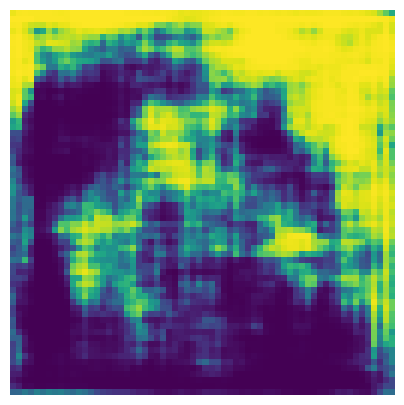

In [38]:
generate_and_plot_image(gen,seed)